# NSL-KDD - Multi-class Classification

By: Luis David Garcia

The dataset used is the NSL-KDD dataset, focusing specifcally on the DDoS
attacks and for multi-class classification. 

The train dataset is here: https://www.kaggle.com/datasets/hassan06/nslkdd?select=KDDTrain%2B.txt

The test dataset is here: https://www.kaggle.com/datasets/hassan06/nslkdd?select=KDDTest%2B.txt 

## Loading Libraries

In [1]:
# For getting paths
import os

# For data manipulation and preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

# For feature engineering
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# For model building
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For model evaluation
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, classification_report

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For timing
import time

## Dataset Analysis and Cleaning

In [2]:
# Column Labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

# Datasets
train_path = "../datasets/nsl-kdd/KDDTrain+.txt"
test_path = "../datasets/nsl-kdd/KDDTest+.txt"

df_train=pd.read_csv(train_path,header=None,names=columns)
df_test=pd.read_csv(test_path,header=None,names=columns)

In [3]:
# Training Set Preview
print(df_train.shape)
print("--------------------")
print(df_train.head())
print("--------------------")
print(df_train.info())

(125973, 43)
--------------------
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60             

In [4]:
df_train['service'].unique()

array(['ftp_data', 'other', 'private', 'http', 'remote_job', 'name',
       'netbios_ns', 'eco_i', 'mtp', 'telnet', 'finger', 'domain_u',
       'supdup', 'uucp_path', 'Z39_50', 'smtp', 'csnet_ns', 'uucp',
       'netbios_dgm', 'urp_i', 'auth', 'domain', 'ftp', 'bgp', 'ldap',
       'ecr_i', 'gopher', 'vmnet', 'systat', 'http_443', 'efs', 'whois',
       'imap4', 'iso_tsap', 'echo', 'klogin', 'link', 'sunrpc', 'login',
       'kshell', 'sql_net', 'time', 'hostnames', 'exec', 'ntp_u',
       'discard', 'nntp', 'courier', 'ctf', 'ssh', 'daytime', 'shell',
       'netstat', 'pop_3', 'nnsp', 'IRC', 'pop_2', 'printer', 'tim_i',
       'pm_dump', 'red_i', 'netbios_ssn', 'rje', 'X11', 'urh_i',
       'http_8001', 'aol', 'http_2784', 'tftp_u', 'harvest'], dtype=object)

In [5]:
# Testing Set Preview
print(df_test.shape)
print("--------------------")
print(df_test.head())
print("--------------------")
print(df_test.info())

(22544, 43)
--------------------
   duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         0           tcp   private   REJ          0          0     0   
1         0           tcp   private   REJ          0          0     0   
2         2           tcp  ftp_data    SF      12983          0     0   
3         0          icmp     eco_i    SF         20          0     0   
4         1           tcp    telnet  RSTO          0         15     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.04   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.61   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    0.31   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.06                         0.00   
1                    0.06        

### Checks - Duplicates, Missing, Distribution, Types

In [6]:
# Check for duplicates
print("Duplicates in Train: ", df_train.duplicated().sum())
print("Duplicates in Test: ", df_test.duplicated().sum())

# Check for missing values
print("-----------------------------------")
print("Rows with missing values - train: ", df_train.isnull().sum())
print("-----------------------------------")
print("Rows with missing values - test: ", df_test.isnull().sum())

Duplicates in Train:  0
Duplicates in Test:  0
-----------------------------------
Rows with missing values - train:  duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate             

### Training Attack Distribution

-----------------------------------
Distribution of Dataset - train: 
attack
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64


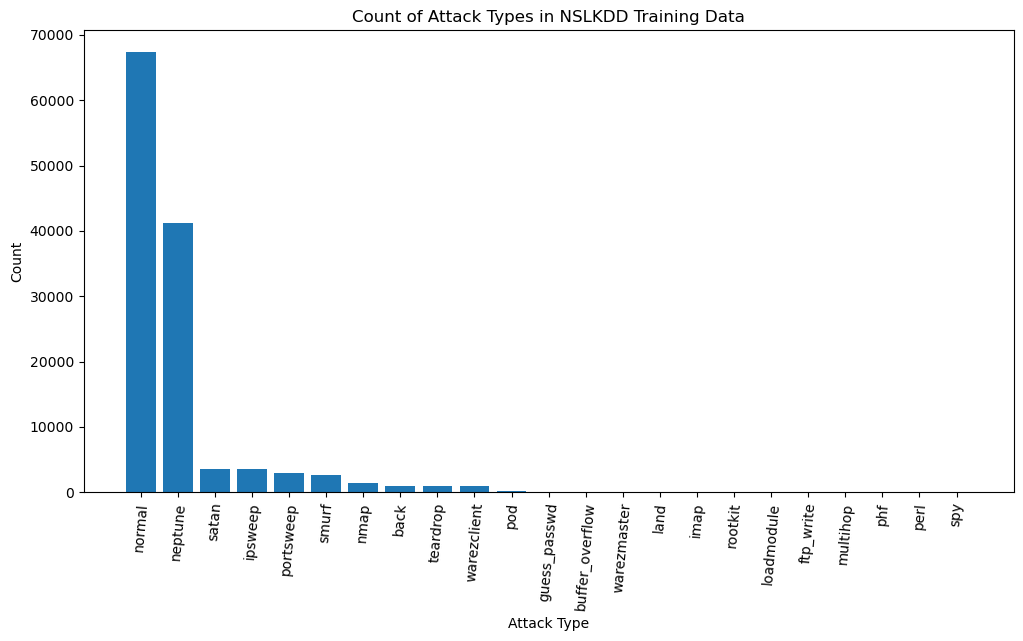

In [7]:
# Check for distribution - Train
print("-----------------------------------")
print("Distribution of Dataset - train: ")
attack_counts_train = df_train['attack'].value_counts()
print(attack_counts_train)

# Create a bar plot
plt.figure(figsize=(12,6))
plt.bar(attack_counts_train.index, attack_counts_train.values)
plt.xticks(rotation=85)
plt.title("Count of Attack Types in NSLKDD Training Data")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.show()

### Testing Attack Distribution

-----------------------------------
Distribution of Dataset - Test: 
attack
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
rootkit              13
xterm                13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
worm                  2
loadmodule            2
perl                  2
sqlattack             2
udpstorm              2
phf                   2
imap                  1
Name: count,

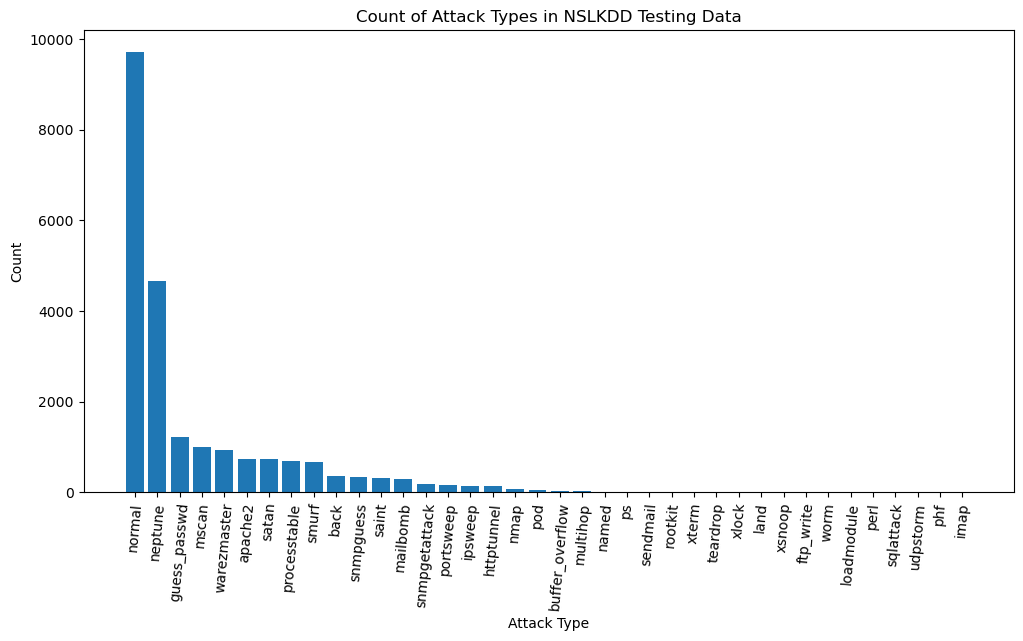

In [8]:
# Check for distribution - Test
print("-----------------------------------")
print("Distribution of Dataset - Test: ")
attack_counts_test = df_test['attack'].value_counts()
print(attack_counts_test)

# Create a bar plot
plt.figure(figsize=(12,6))
plt.bar(attack_counts_test.index, attack_counts_test.values)
plt.xticks(rotation=85)
plt.title("Count of Attack Types in NSLKDD Testing Data")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.show()

### Attack Reduction

#### Multi-class Classification Data

In [9]:
# Must reduce to only attacks known in the training set

# List of DDoS/DoS attacks for the training dataset
train_ddos = [
    "neptune",
    "smurf",
    "pod",
    "teardrop",
    "land",
    "back"
]

# List of DDoS/DoS attacks for the test dataset, including unknowns
test_ddos = [
    "apache2",
    "processtable",
    "mailbomb",
    "udpstorm",
    "worm",
    "processtable"
]

# Combine DDoS/DoS attacks for filtering
all_train_attacks = train_ddos
all_test_attacks = all_train_attacks

# Filtering df_train to keep only 'normal', train_ddos, and scanning attacks
df_train_multiclass = df_train[df_train['attack'].isin(['normal'] + all_train_attacks)]

# Filtering df_test to keep only 'normal' and test_ddos, including known DDoS attacks
df_test_multiclass = df_test[df_test['attack'].isin(['normal'] + all_test_attacks)]

# Group non-DDoS/DoS attacks and scanning attacks in the test set as 'suspicious'
# df_test_multiclass['attack'] = df_test['attack'].apply(
#     lambda x: 'suspicious' if x not in ['normal'] + train_ddos else x
# )

# Displaying the filtered DataFrames
print("Filtered df_train for DDoS and scanning attacks:")
print(df_train_multiclass['attack'].value_counts())

print("-------------------------------")

print("\nFiltered df_test for DDoS (excluding known DDoS attacks):")
print(df_test_multiclass['attack'].value_counts())


Filtered df_train for DDoS and scanning attacks:
attack
normal      67343
neptune     41214
smurf        2646
back          956
teardrop      892
pod           201
land           18
Name: count, dtype: int64
-------------------------------

Filtered df_test for DDoS (excluding known DDoS attacks):
attack
normal      9711
neptune     4657
smurf        665
back         359
pod           41
teardrop      12
land           7
Name: count, dtype: int64


#### Plotting of the Attack Distribution

In [10]:
# Helper function to plot bar labels
def add_bar_labels(bars):
    # Add counts on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height}',
            ha='center',
            va='bottom'
        )

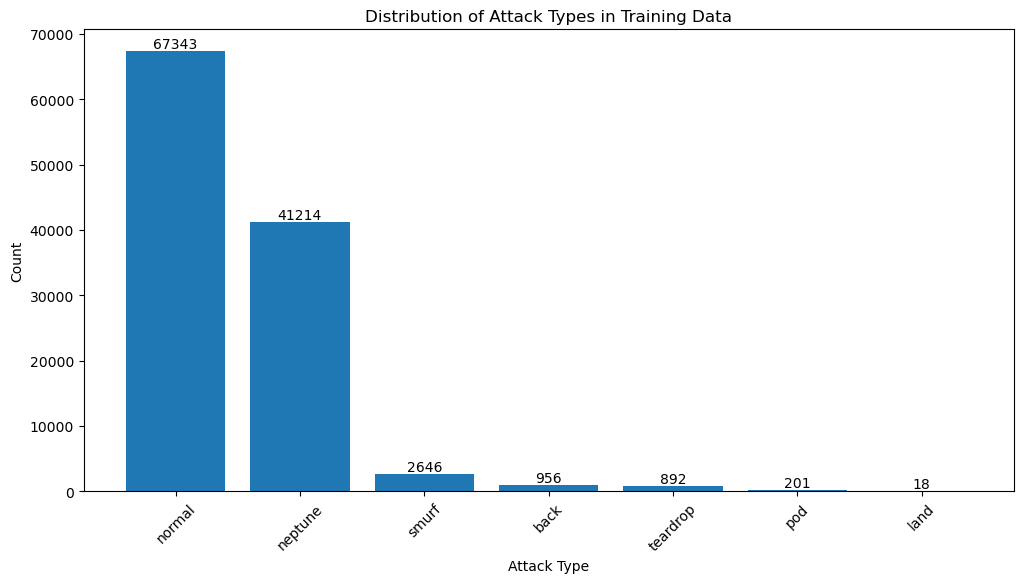

In [11]:
# Plot of Training DDoS Attack Distribution
attack_counts_train = df_train_multiclass['attack'].value_counts()
plt.figure(figsize=(12, 6))
bars = plt.bar(attack_counts_train.index, attack_counts_train.values)
add_bar_labels(bars)
plt.xticks(rotation=45)
plt.title("Distribution of Attack Types in Training Data")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.show()

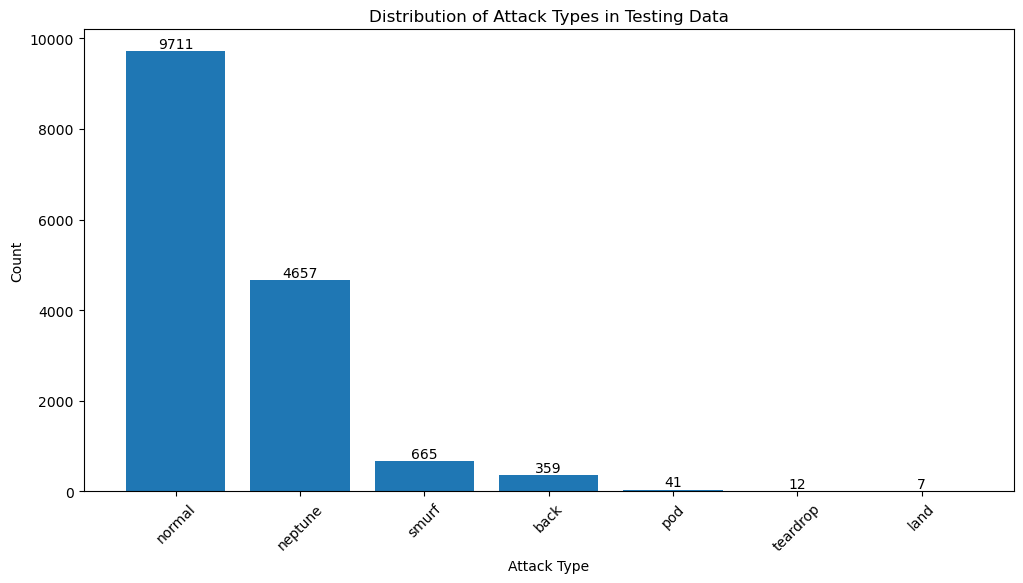

In [12]:
# Plot of Testing DDoS Attacks
attack_counts_test = df_test_multiclass['attack'].value_counts()

plt.figure(figsize=(12,6))
plt.title("Distribution of Attack Types in Testing Data")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
bars = plt.bar(attack_counts_test.index, attack_counts_test.values)
add_bar_labels(bars)
plt.show()

In [51]:
# Check Types of Object
df_train.select_dtypes(['object']).columns

Index(['protocol_type', 'service', 'flag', 'attack'], dtype='object')

### Encode Data - Multiclass

In [52]:
# Encode categorical features (including 'attack')
columns_to_encode = ['protocol_type', 'service', 'flag', 'attack']
label_map = {}

for column in columns_to_encode:
    le = LabelEncoder()
    
    # Fit the label encoder only on the training data
    le.fit(df_train_multiclass[column])
    
    df_train_multiclass[column] = le.transform(df_train_multiclass[column])
    
    # Transform test data with handling for unseen labels
    df_test_multiclass[column] = df_test_multiclass[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    
    # Store the mapping for reference
    label_map[column] = dict(zip(le.classes_, le.transform(le.classes_)))

# Display the label map
for column, mapping in label_map.items():
    print(f"Mapping for {column}: {mapping}")


/var/folders/cs/q9gsmhxd20v2qj9n_hb2hv8m0000gn/T/ipykernel_62917/3758552938.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_multiclass[column] = le.transform(df_train_multiclass[column])
/var/folders/cs/q9gsmhxd20v2qj9n_hb2hv8m0000gn/T/ipykernel_62917/3758552938.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_multiclass[column] = df_test_multiclass[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
/var/folders/cs/q9gsmhxd20v2qj9n_hb2hv8m0000gn/T/ipykernel_6

Mapping for protocol_type: {'icmp': 0, 'tcp': 1, 'udp': 2}
Mapping for service: {'IRC': 0, 'X11': 1, 'Z39_50': 2, 'auth': 3, 'bgp': 4, 'courier': 5, 'csnet_ns': 6, 'ctf': 7, 'daytime': 8, 'discard': 9, 'domain': 10, 'domain_u': 11, 'echo': 12, 'eco_i': 13, 'ecr_i': 14, 'efs': 15, 'exec': 16, 'finger': 17, 'ftp': 18, 'ftp_data': 19, 'gopher': 20, 'hostnames': 21, 'http': 22, 'http_443': 23, 'imap4': 24, 'iso_tsap': 25, 'klogin': 26, 'kshell': 27, 'ldap': 28, 'link': 29, 'login': 30, 'mtp': 31, 'name': 32, 'netbios_dgm': 33, 'netbios_ns': 34, 'netbios_ssn': 35, 'netstat': 36, 'nnsp': 37, 'nntp': 38, 'ntp_u': 39, 'other': 40, 'pop_2': 41, 'pop_3': 42, 'printer': 43, 'private': 44, 'red_i': 45, 'remote_job': 46, 'rje': 47, 'shell': 48, 'smtp': 49, 'sql_net': 50, 'ssh': 51, 'sunrpc': 52, 'supdup': 53, 'systat': 54, 'telnet': 55, 'tftp_u': 56, 'tim_i': 57, 'time': 58, 'urh_i': 59, 'urp_i': 60, 'uucp': 61, 'uucp_path': 62, 'vmnet': 63, 'whois': 64}
Mapping for flag: {'OTH': 0, 'REJ': 1, 'RSTO

/var/folders/cs/q9gsmhxd20v2qj9n_hb2hv8m0000gn/T/ipykernel_62917/3758552938.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_multiclass[column] = df_test_multiclass[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)


### Removal of Features not in Network Traffic Analyzers

In [53]:
# "land," since this would have to be a check to see if src ip = dest ip
non_directly_obtainable_features = [
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'land',
    'level',   
]

x_train = df_train_multiclass.drop(non_directly_obtainable_features, axis=1)
x_test = df_test_multiclass.drop(non_directly_obtainable_features, axis=1)

### Splitting of Data

In [54]:
# Split the data into features (x) and target (y) - Level is unknown in real-time
x_train = x_train.drop('attack', axis=1)
y_train = df_train_multiclass['attack']
x_test = x_test.drop('attack', axis=1)
y_test = df_test_multiclass['attack']

In [55]:
# Ratio of Training to Testing Data
# Step 1: Determine the sizes of training and test sets
train_size = len(df_train)
test_size = len(df_test)

# Step 2: Calculate the total number of samples
total_size = train_size + test_size

# Step 3: Calculate the ratios
train_ratio = train_size / total_size
test_ratio = test_size / total_size

print(f"Train ratio: {train_ratio:.2f}")
print(f"Test ratio: {test_ratio:.2f}")


Train ratio: 0.85
Test ratio: 0.15


## Feature Engineering

In [16]:
# Mutual Information for feature selection
mutual_info = mutual_info_classif(x_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = x_train.columns
mutual_info.sort_values(ascending=False)

src_bytes                      0.931444
service                        0.762132
flag                           0.675944
diff_srv_rate                  0.656311
same_srv_rate                  0.625269
dst_host_diff_srv_rate         0.616361
count                          0.563341
dst_host_same_srv_rate         0.561941
dst_host_srv_count             0.541540
dst_bytes                      0.501865
dst_host_serror_rate           0.501065
serror_rate                    0.475274
dst_host_srv_serror_rate       0.447068
srv_serror_rate                0.425225
dst_host_same_src_port_rate    0.385678
dst_host_srv_diff_host_rate    0.324601
srv_count                      0.294895
dst_host_count                 0.293776
protocol_type                  0.260929
dst_host_rerror_rate           0.201847
srv_diff_host_rate             0.184934
dst_host_srv_rerror_rate       0.152194
rerror_rate                    0.150517
srv_rerror_rate                0.103855
duration                       0.074154


<Axes: >

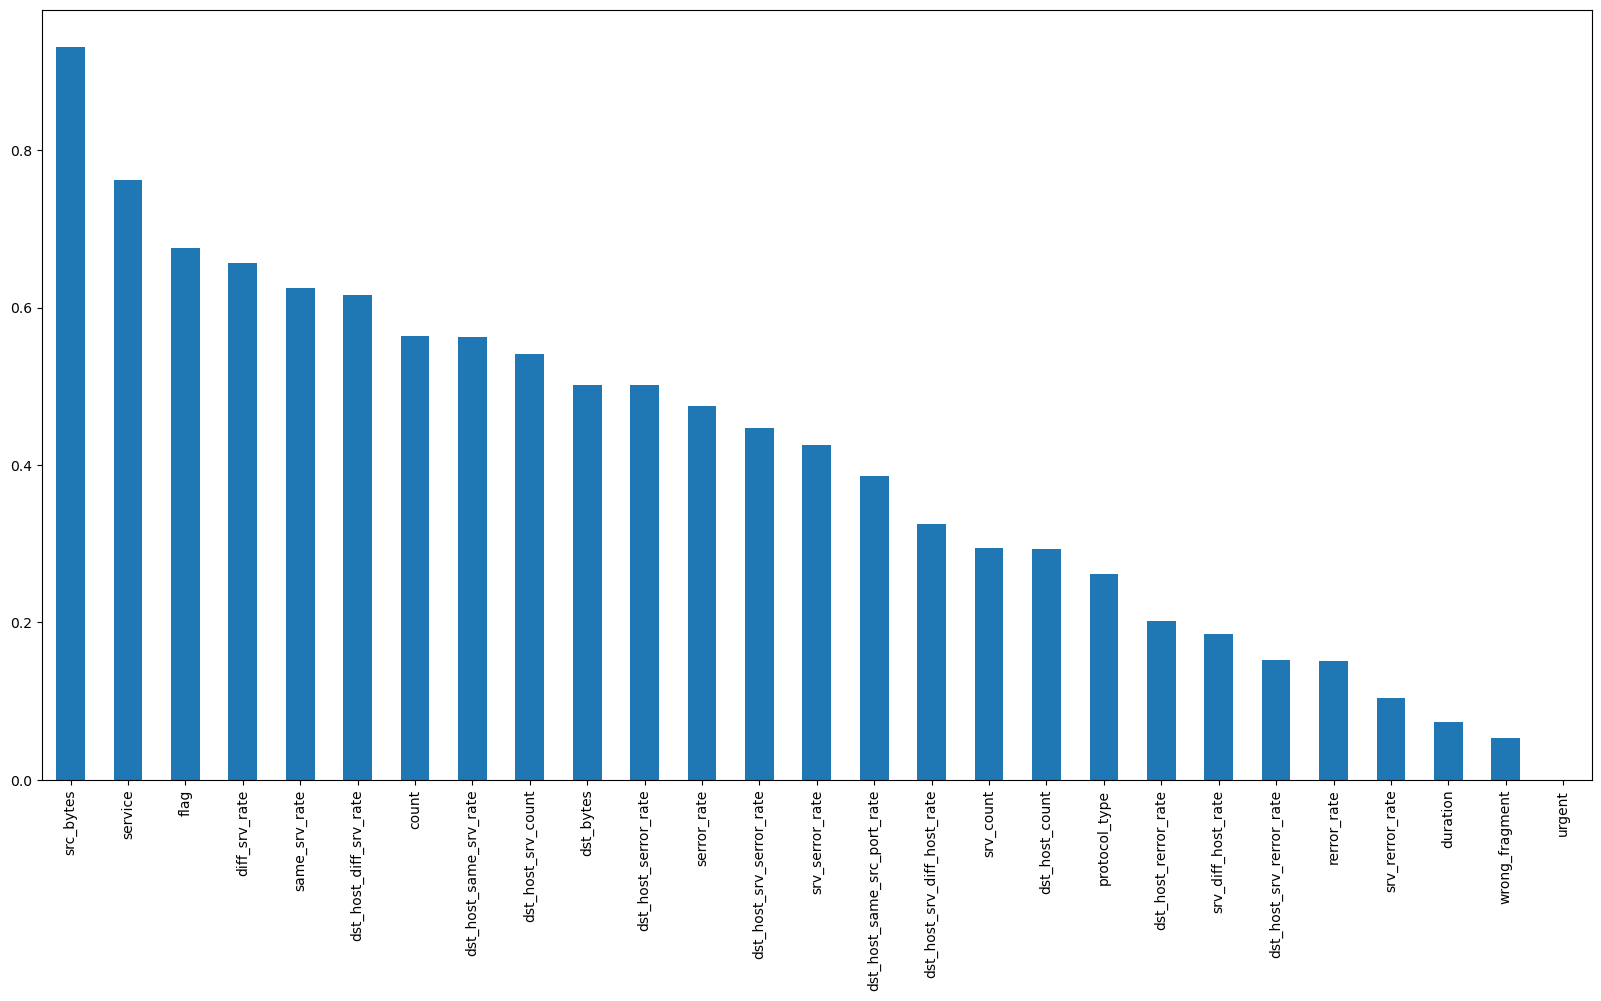

In [17]:
# Display in bar chart
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20,10))

In [16]:
# Just Drop Urgent
x_train = x_train.drop('urgent', axis=1)
x_test = x_test.drop('urgent', axis=1)


In [56]:
# SelectKBest for Top 20 Features
top_20_features = SelectKBest(mutual_info_classif, k=4)
top_20_features.fit(x_train, y_train)
x_train.columns[top_20_features.get_support()]

Index(['service', 'flag', 'src_bytes', 'diff_srv_rate'], dtype='object')

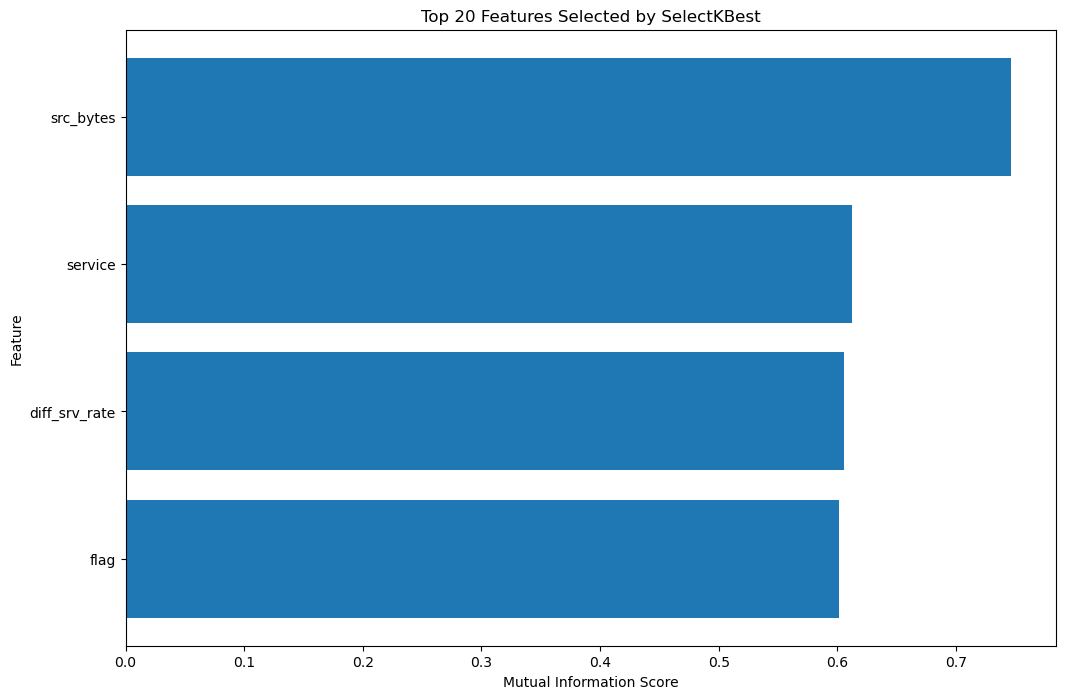

In [57]:
# Get the mask for the selected features
mask = top_20_features.get_support()

# Get the feature scores
feature_scores = top_20_features.scores_

# Get the selected feature names
selected_features = x_train.columns[mask]
selected_scores = feature_scores[mask]

# Create a DataFrame for plotting
df_top_features = pd.DataFrame({
    'Feature': selected_features,
    'Score': selected_scores
})

# Sort the DataFrame by scores in descending order
df_top_features = df_top_features.sort_values(by='Score', ascending=False)

# Plot the top features
plt.figure(figsize=(12, 8))
plt.barh(df_top_features['Feature'], df_top_features['Score'])
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Top 20 Features Selected by SelectKBest')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score on top
plt.show()


In [58]:
top_20_features = ['service', 'flag', 'src_bytes', 'diff_srv_rate']

# ['service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'same_srv_rate',
#        'diff_srv_rate', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
#        'dst_host_serror_rate']

# ['protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'count',
#        'srv_count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate',
#        'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
#        'dst_host_srv_count', 'dst_host_same_srv_rate',
#        'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
#        'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
#        'dst_host_srv_serror_rate']

x_train= x_train[top_20_features]
x_test= x_test[top_20_features]

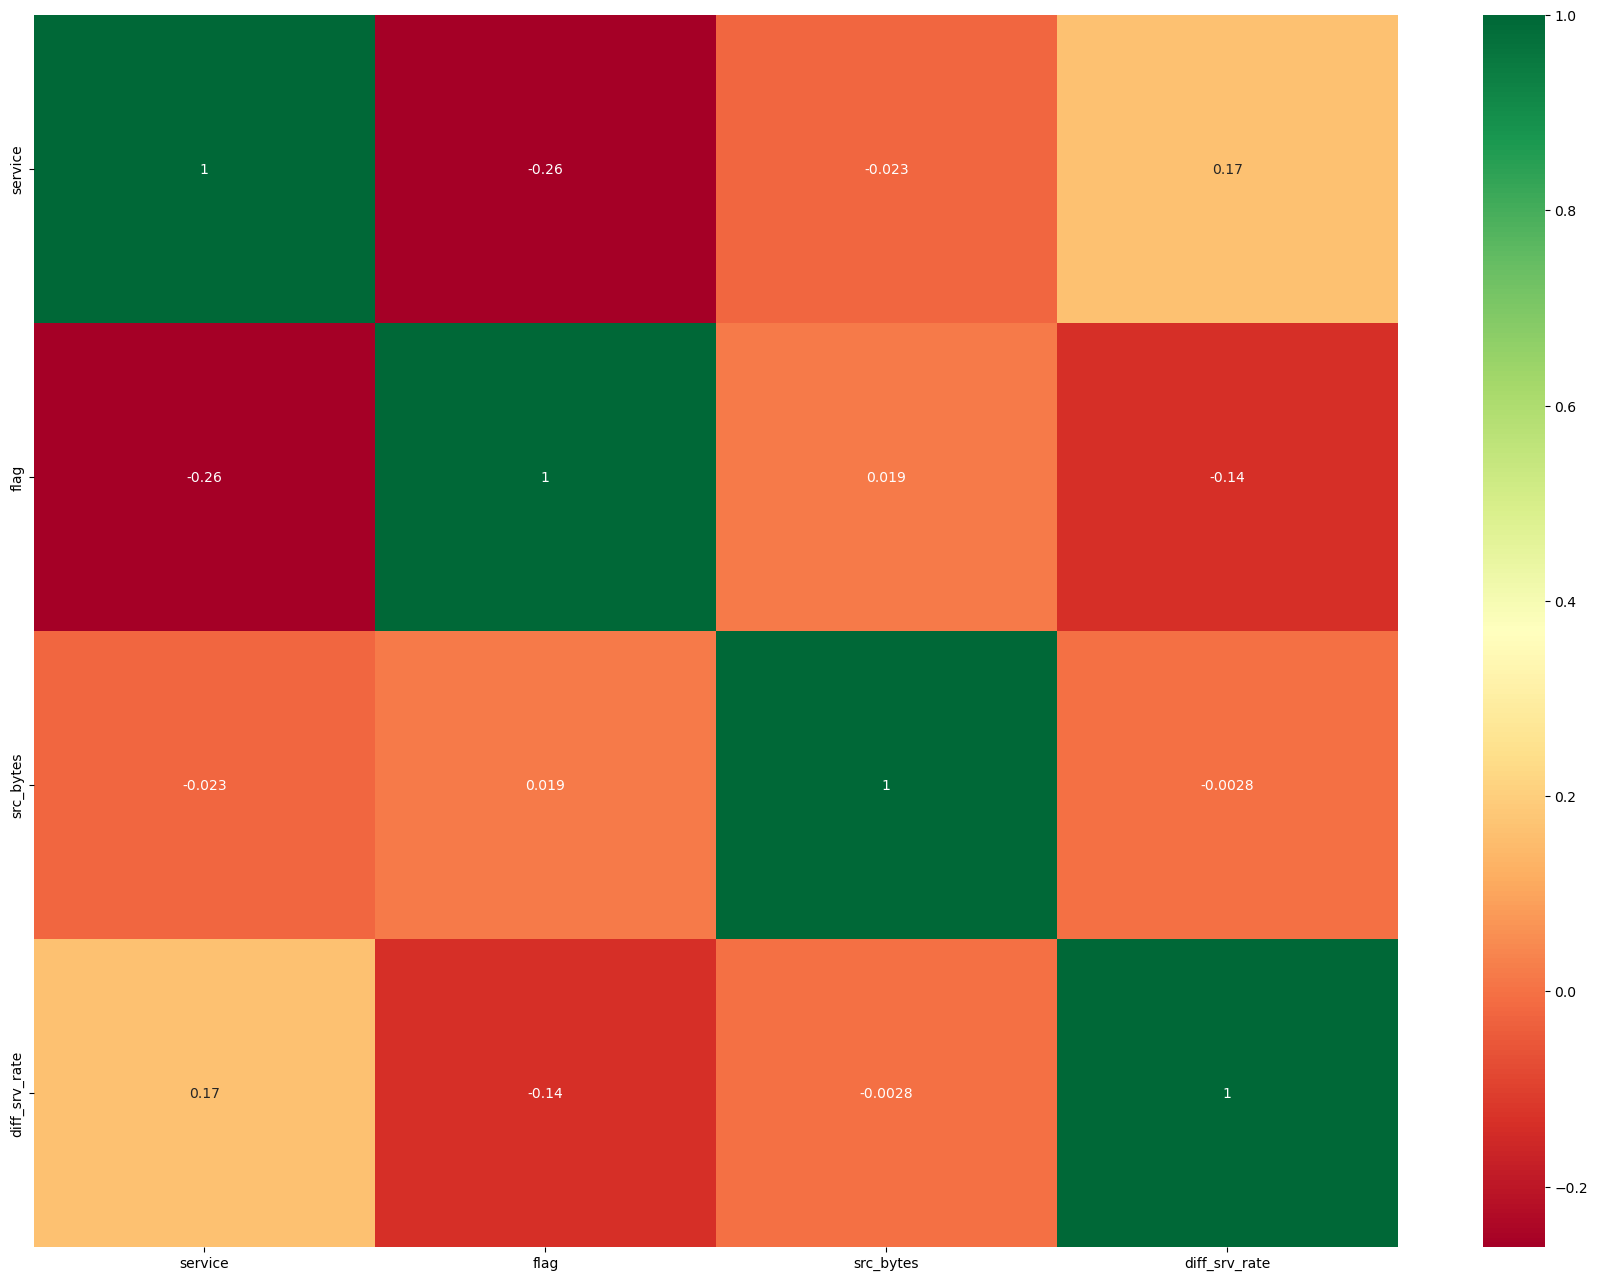

In [59]:
plt.figure(figsize=(22,16))
top_20_heatmap = sns.heatmap(x_train.corr(), annot=True, cmap='RdYlGn')

### Scaling

In [60]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
sampled = False

In [61]:
print(x_train.shape)
print(x_test.shape)

(113270, 4)
(15452, 4)


## Results of Traditional ML Models for Multiclass Classification

In [62]:
import joblib

# Create the classifiers
models = {
    "XGBoost": XGBClassifier(
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Decision Tree": DecisionTreeClassifier(),
}


# Train and evaluate each model
results = {}

for name, model in models.items():
    # Train the model
    start_train_time = time.time()
    model.fit(x_train, y_train)
    end_train_time = time.time()
    train_time = end_train_time - start_train_time

    # Save the trained model
    # model_filename = f"{name.replace(' ', '_').lower()}_multiclass_model.joblib"
    # joblib.dump(model, model_filename)
    # print(f"Model {name} saved as {model_filename}")

    # Predict on the test set
    start_pred_time = time.time()
    y_pred = model.predict(x_test)
    end_pred_time = time.time()
    pred_time = end_pred_time - start_pred_time

    # Decode labels for evaluation
    y_test_decoded = le.inverse_transform(y_test)
    y_pred_decoded = le.inverse_transform(y_pred)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
    precision = precision_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
    recall = recall_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
    f1 = f1_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
    conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)
    class_report = classification_report(y_test_decoded, y_pred_decoded, zero_division=1, digits=5)

    # Store the results
    results[name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "conf_matrix": conf_matrix,
        "class_report": class_report,
        "train_time": train_time,
        "pred_time": pred_time
    }

    # Print evaluation metrics
    print(f'--- {name} ---')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    print(f'Classification Report:\n{class_report}')
    print(f'Training Time: {train_time} seconds')
    print(f'Prediction Time: {pred_time} seconds')


--- XGBoost ---
Accuracy: 0.9879627232720684
Precision: 0.8106166197313546
Recall: 0.8229781169049842
F1 Score: 0.7023786457095278
Confusion Matrix:
[[ 359    0    0    0    0    0    0]
 [   0    0    7    0    0    0    0]
 [   0    0 4646   11    0    0    0]
 [   3    0    9 9618   44    0   37]
 [   0    0    0    5   36    0    0]
 [   0    0    0   70    0  595    0]
 [   0    0    0    0    0    0   12]]
Classification Report:
              precision    recall  f1-score   support

        back    0.99171   1.00000   0.99584       359
        land    1.00000   0.00000   0.00000         7
     neptune    0.99657   0.99764   0.99710      4657
      normal    0.99114   0.99042   0.99078      9711
         pod    0.45000   0.87805   0.59504        41
       smurf    1.00000   0.89474   0.94444       665
    teardrop    0.24490   1.00000   0.39344        12

    accuracy                        0.98796     15452
   macro avg    0.81062   0.82298   0.70238     15452
weighted avg    0.9

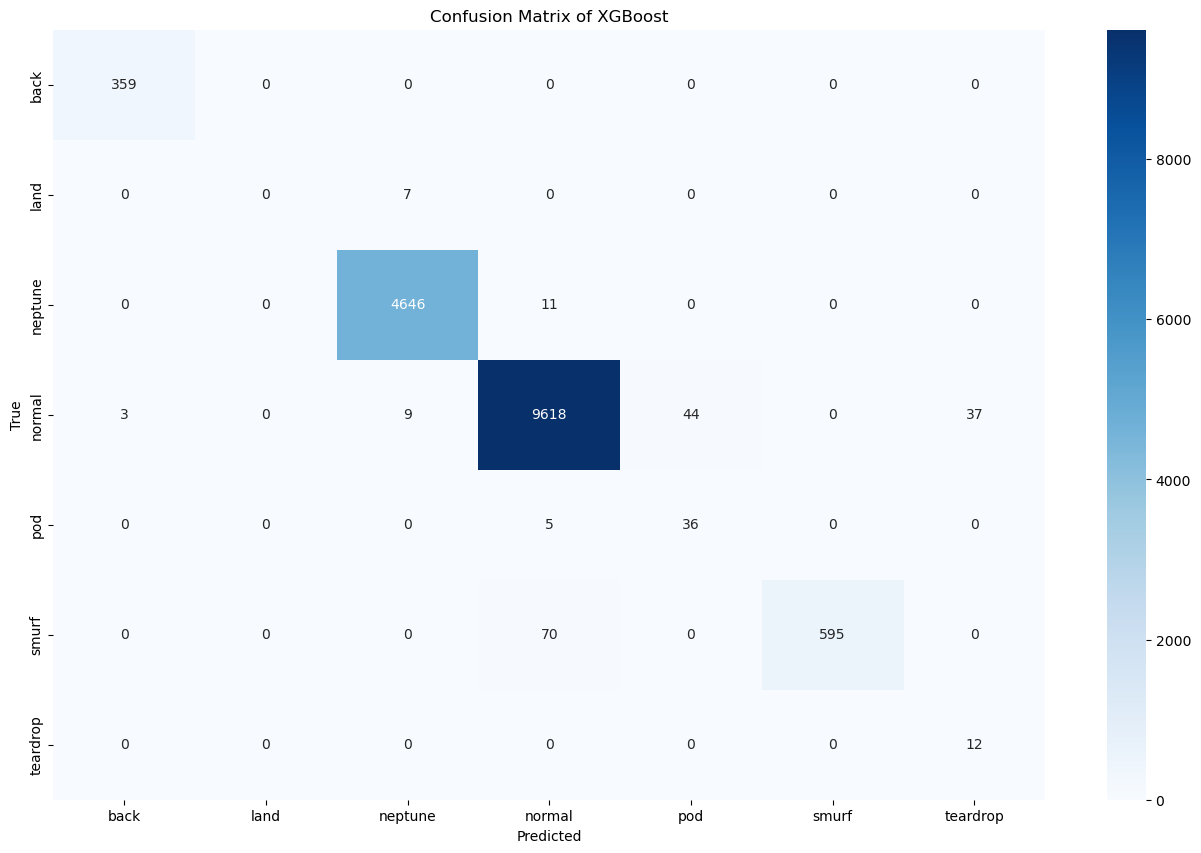

In [63]:
# Plot confusion matrix
plt.figure(figsize=(16, 10))
sns.heatmap(results['XGBoost']['conf_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of XGBoost')
plt.show()

## Deep Learning - Hybrid Model AE-XGB 

In [64]:
import tensorflow as tf
import time

### Data Reshaping

In [65]:
print(x_train.shape)
print(x_test.shape)

(113270, 4)
(15452, 4)


In [26]:
# Reshape the data for the autoencoder
balanced = False
if balanced:
    print("Balanced Version")
else:
    x_train_reshaped = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))  

x_test_reshaped = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [27]:
# Get the input dimension
input_dim = x_train_reshaped.shape[1]
print(input_dim)

10


### Autoencoder Creation

In [31]:
# Define the autoencoder model
autoencoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim, 1)),
    tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2, padding='same'),
    tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu', name='bottleneck'),
    tf.keras.layers.Dense(((input_dim // 4)) * 16, activation='relu'),
    tf.keras.layers.Reshape(((input_dim // 4), 16)),
    tf.keras.layers.UpSampling1D(2),
    tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same'),
    tf.keras.layers.UpSampling1D(2),
    tf.keras.layers.ZeroPadding1D(padding=(1)),
    tf.keras.layers.Conv1D(1, 3, activation='tanh', padding='same')
])

# Compile the autoencoder
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Print the model summary
print(autoencoder.summary())

# Extract the encoder part 
encoder = tf.keras.Sequential(autoencoder.layers[:7])
encoder.build(input_shape=(None, input_dim, 1))
print(encoder.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 5, 16)          │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 3, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 2, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_4 (UpSampling1D)  │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 4, 16)          │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_5 (UpSampling1D)  │ (None, 8, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding1d_1                │ (None, 10, 16)         │             0 │
│ (ZeroPadding1D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 10, 1)          │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,841 (15.00 KB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 5, 16)          │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 3, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,008 (11.75 KB)

 Trainable params: 3,008 (11.75 KB)

 Non-trainable params: 0 (0.00 B)

None


### Autoencoder Training

In [32]:
autoencoder_start_time = time.time()
# Train the autoencoder on both benign and attack samples
autoencoder.fit(
    x_train_reshaped, 
    x_train_reshaped, 
    epochs=100, 
    batch_size=64, 
    shuffle=True, 
    validation_split=0.2,
)
autoencoder_end_time = time.time()
autoencoder_training_time = autoencoder_end_time - autoencoder_start_time


Epoch 1/100
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4454 - val_loss: 0.7348
Epoch 2/100
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3764 - val_loss: 0.7299
Epoch 3/100
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3576 - val_loss: 0.7285
Epoch 4/100
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2926 - val_loss: 0.7266
Epoch 5/100
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3057 - val_loss: 0.7261
Epoch 6/100
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2849 - val_loss: 0.7257
Epoch 7/100
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2971 - val_loss: 0.7253
Epoch 8/100
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3106 - val_loss: 0.7252
Epoch 9/100
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2694 - val_loss: 0.7252
Epoch 10/100
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2974 - val_loss: 0.7247
Epoch 11/100
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3330 - val_loss: 0.7247
Epoch 12/100
1416/1

### Encoding of Data using Trained Autoencoder for XGB

In [36]:
# Save the trained autoencoder model
autoencoder.save('nslkdd_trained_autoencoder.keras')

# Extract the encoder part
encoder = tf.keras.Sequential(autoencoder.layers[:7])
encoder.build(input_shape=(None, input_dim, 1))

# Print the encoder model summary
print(encoder.summary())

# Save the encoder model
encoder.save('nslkdd_trained_encoder.keras')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80)             │         1,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,336 (16.94 KB)

 Trainable params: 4,336 (16.94 KB)

 Non-trainable params: 0 (0.00 B)

None


In [37]:
# Encode the train and test data using the trained encoder
encoded_train = encoder.predict(x_train_reshaped)
encoded_test = encoder.predict(x_test_reshaped)

3540/3540 ━━━━━━━━━━━━━━━━━━━━ 1s 371us/step
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


### Run this cell only if you saved the encoder model and want to load it

In [71]:
# Load the encoder model
encoder = tf.keras.models.load_model('nslkdd_trained_encoder.keras')

### Acquire Latent Representation for Autoencoder

In [33]:
# Encode the train and test data using the trained encoder
encoded_train = encoder.predict(x_train_reshaped)
encoded_test = encoder.predict(x_test_reshaped)

3540/3540 ━━━━━━━━━━━━━━━━━━━━ 1s 368us/step
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


### Combine Encoded and Original Features

In [34]:
# Flatten the encoded data for training XGBoost
encoded_train_flat = encoded_train.reshape((encoded_train.shape[0], -1))
encoded_test_flat = encoded_test.reshape((encoded_test.shape[0], -1))

## Results of Hybrid AE-XGB Model

In [35]:
# Create the XGBoost classifier
model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False
)

# Train the model
start_train_time = time.time()
model.fit(encoded_train_flat, y_train, verbose=True)
end_train_time = time.time()
train_time = end_train_time - start_train_time

# Save the trained model
model_filename = "ae_xgb_model_multiclass.joblib"
joblib.dump(model, model_filename)
print(f"Model {name} saved as {model_filename}")

# Predict on the test set
start_pred_time = time.time()
y_pred = model.predict(encoded_test_flat)
end_pred_time = time.time()
pred_time = end_pred_time - start_pred_time

# Decode labels for evaluation
y_test_decoded = le.inverse_transform(y_test)
y_pred_decoded = le.inverse_transform(y_pred)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
precision = precision_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
recall = recall_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
f1 = f1_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)
class_report = classification_report(y_test_decoded, y_pred_decoded, digits=5, zero_division=1)

# Store the results
results = {}
results["xgboost"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "conf_matrix": conf_matrix,
    "class_report": class_report,
    "train_time": train_time,
    "pred_time": pred_time
}

# Print evaluation metrics
print(f'--- {"xgboost"} ---')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')
print(f'Training Time: {train_time} seconds')
print(f'Prediction Time: {pred_time} seconds')

Model Decision Tree saved as ae_xgb_model_multiclass.joblib
--- xgboost ---
Accuracy: 0.9796142894123738
Precision: 0.8228289669884788
Recall: 0.7569826325017236
F1 Score: 0.762270279893342
Confusion Matrix:
[[ 186    0    0  173    0    0    0]
 [   0    4    1    2    0    0    0]
 [   0    0 4616   41    0    0    0]
 [   3    0   12 9657   13    4   22]
 [   0    0    0    6   35    0    0]
 [   0    0    0   23    8  634    0]
 [   0    0    0    7    0    0    5]]
Classification Report:
              precision    recall  f1-score   support

        back    0.98413   0.51811   0.67883       359
        land    1.00000   0.57143   0.72727         7
     neptune    0.99719   0.99120   0.99418      4657
      normal    0.97457   0.99444   0.98440      9711
         pod    0.62500   0.85366   0.72165        41
       smurf    0.99373   0.95338   0.97314       665
    teardrop    0.18519   0.41667   0.25641        12

    accuracy                        0.97961     15452
   macro avg  

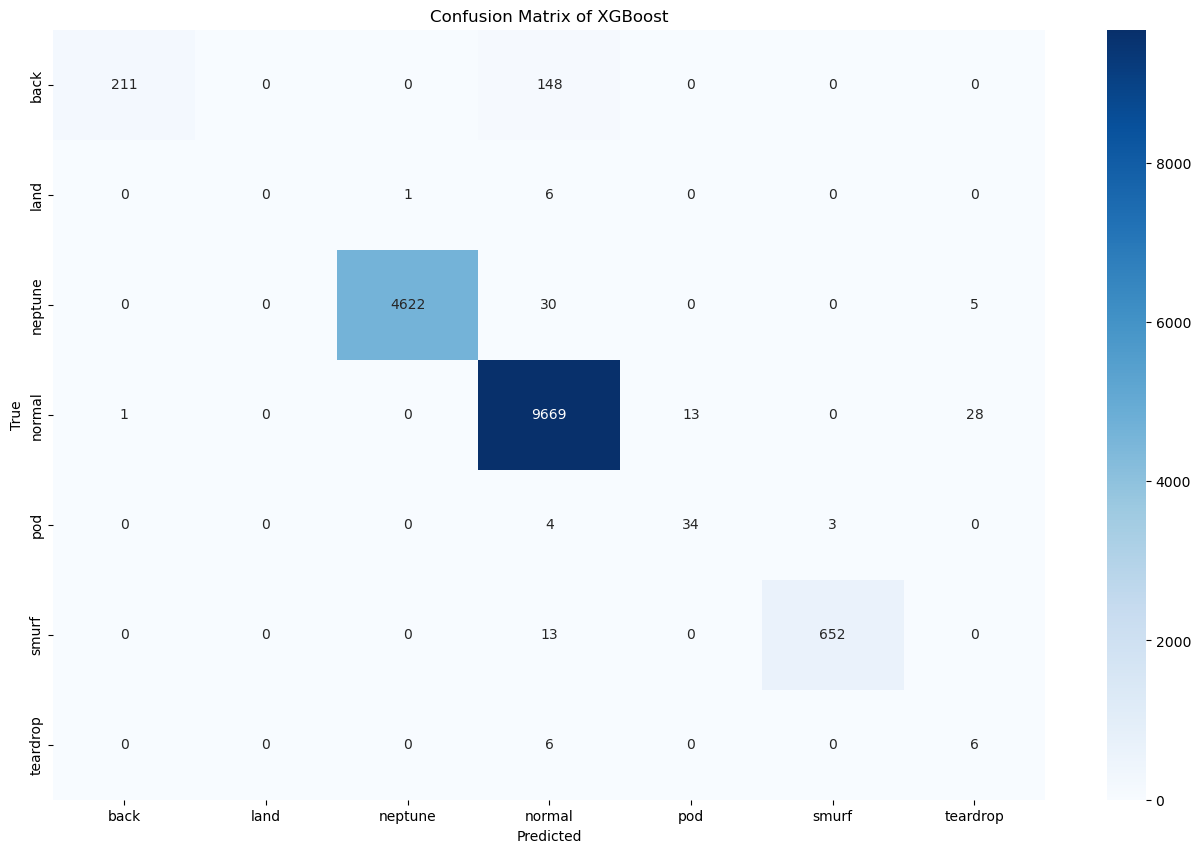

In [76]:
# Plot confusion matrix
plt.figure(figsize=(16, 10))
sns.heatmap(results['xgboost']['conf_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of XGBoost')
plt.show()

## Deep Learning - CNN-LSTM

### Model Creation



In [66]:
# Reshape x_train and x_test to 3D for CNN-LSTM
x_train_reshaped = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))  # shape becomes (125973, 4, 1)
x_test_reshaped = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))      # shape becomes (22544, 4, 1)


In [77]:
print(x_train_reshaped.shape)

(113270, 4, 1)


In [68]:
import tensorflow as tf

# Number of output classes
num_classes = 7  # Adjust this based on your actual number of classes

cnn_lstm_model = tf.keras.models.Sequential([
    # Input shape (4 time steps, 1 feature per time step)
    tf.keras.layers.Input(shape=(x_train.shape[1], 1)),
    
    # First Conv1D Layer
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=1),  # Pooling reduced to prevent over-reduction
    
    # LSTM Layer
    tf.keras.layers.LSTM(50),  # One LSTM layer with 50 units

    # Fully Connected Layer
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Dropout for regularization
    
    # Output layer for multiclass classification
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Softmax for multiclass classification
])

# Compile the model
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
cnn_lstm_model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 3, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,999 (113.28 KB)

 Trainable params: 28,999 (113.28 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Convert y_train and y_test to one-hot encoding
y_train_reshaped = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_reshaped = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

print(y_train_reshaped.shape)  # Should print (125973, 7)
print(y_test_reshaped.shape)   # Should print (22544, 7)


(113270, 7)
(15452, 7)


In [73]:
import time

# Record the start time
start_time = time.time()

# Train the model
history = cnn_lstm_model.fit(x_train_reshaped, y_train_reshaped, epochs=30, batch_size=64, validation_data=(x_test_reshaped, y_test_reshaped))

# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

# Print the training time
print(f"Training time: {training_time:.2f} seconds")

# Save the trained model to a file
cnn_lstm_model.save('cnn_lstm_model_multiclass.keras')  
print("Model saved as 'cnn_lstm_model_multiclass.keras'")

Epoch 1/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9083 - loss: 0.3645 - val_accuracy: 0.9865 - val_loss: 0.0715
Epoch 2/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9845 - loss: 0.0421 - val_accuracy: 0.9419 - val_loss: 0.0940
Epoch 3/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9848 - loss: 0.0375 - val_accuracy: 0.9905 - val_loss: 0.0680
Epoch 4/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9849 - loss: 0.0369 - val_accuracy: 0.9449 - val_loss: 0.0834
Epoch 5/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9870 - loss: 0.0322 - val_accuracy: 0.9454 - val_loss: 0.0759
Epoch 6/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9867 - loss: 0.0313 - val_accuracy: 0.9451 - val_loss: 0.1086
Epoch 7/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9878 - loss: 0.0296 - val_accuracy: 0.9902 - val_loss: 0.0696
Epoch 8/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9857 - loss: 0.0335 - 

In [74]:
loss, accuracy = cnn_lstm_model.evaluate(x_test_reshaped, y_test_reshaped)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.9453 - loss: 0.0886
Test Loss: 0.08240281790494919
Test Accuracy: 0.9451203942298889


In [75]:
# Make predictions on the test data
start_pred_time = time.time()
y_pred = cnn_lstm_model.predict(x_test_reshaped)
end_pred_time = time.time()
pred_time = end_pred_time - start_pred_time
print(f"Prediction time: {pred_time:.2f} seconds")

# Convert predictions from probabilities to class labels (argmax to get the index of the max probability)
y_pred_classes = np.argmax(y_pred, axis=1)

# y_test is one-hot encoded, so you need to reverse that
y_true_classes = np.argmax(y_test_reshaped, axis=1)

# Decode the integer-encoded labels back to the original categorical labels using LabelEncoder
y_pred_decoded = le.inverse_transform(y_pred_classes)
y_test_decoded = le.inverse_transform(y_true_classes)

# Print the decoded predictions and true labels
print("Predicted Labels:", y_pred_decoded)
print("True Labels:", y_test_decoded)


483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
Prediction time: 0.32 seconds
Predicted Labels: ['neptune' 'neptune' 'normal' ... 'normal' 'back' 'normal']
True Labels: ['neptune' 'neptune' 'normal' ... 'normal' 'back' 'normal']


In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
precision = precision_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
recall = recall_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
f1 = f1_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision (macro-average): {precision:.5f}")
print(f"Recall (macro-average): {recall:.5f}")
print(f"F1 Score (macro-average): {f1:.5f}")


Accuracy: 0.94512
Precision (macro-average): 0.84050
Recall (macro-average): 0.70189
F1 Score (macro-average): 0.55960


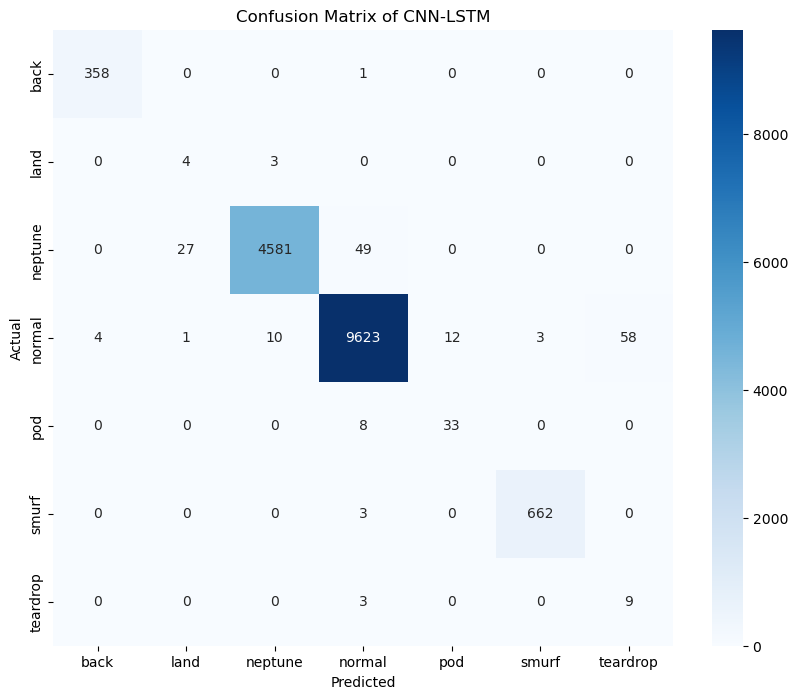

              precision    recall  f1-score   support

        back    0.98895   0.99721   0.99307       359
        land    0.12500   0.57143   0.20513         7
     neptune    0.99717   0.98368   0.99038      4657
      normal    0.99339   0.99094   0.99216      9711
         pod    0.73333   0.80488   0.76744        41
       smurf    0.99549   0.99549   0.99549       665
    teardrop    0.13433   0.75000   0.22785        12

    accuracy                        0.98822     15452
   macro avg    0.70967   0.87052   0.73879     15452
weighted avg    0.99277   0.98822   0.99024     15452



In [106]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

# Define the number of classes (assuming le.classes_ gives the correct number of classes)
num_classes = len(le.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of CNN-LSTM')
plt.show()

# Print the classification report
print(classification_report(y_test_decoded, y_pred_decoded, digits=5))
